<a href="https://colab.research.google.com/github/jchen8000/MachineLearning/blob/master/6%20Recommender%20System/recommender_system_content_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender System - Content Based Filtering

***Abstract***


Content-based filtering is one of the common methods for building recommendation systems. This hands-on practice will build a Content-based filtering Recommender on the  [MovieLens dataset](https://www.kaggle.com/prajitdatta/movielens-100k-dataset). The dataset provides a good amount of information of movie’s features such as action, adventure, animation, comedy and so on, we will utilize these "features" to make following predictions,

*   Analysing the description of contents and make recommendations based on a selected content. For example when a movie is selected, this Recommender will recommend the most similar movies. Based on the features of each movie that we load from the dataset, we calculate the Norm of the feature vector of that movie, then we find the "similar" movie by calculating the minimum difference of two vectors.

*   Building user profile from the user rated contents and make recommendations to users based on his/her ratings. For example, the users rated some of the movies and different users rated different movies, based on these user ratings, we calculate and predict the user profile on all movies for all users, and make recommendations to the user based on this profile. We use linear model with gradient decent to build the model and make predictions.


Related: [Recommender System - Collaborative Filtering](https://nbviewer.jupyter.org/github/jchen8000/MachineLearning/blob/master/6%20Recommender%20System/recommender_system_content_based.ipynb)



In [0]:

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la 
import scipy.io 
import scipy.optimize #Use for fmincg

## 1. Movie ratings dataset

In [0]:

# !wget "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
!wget "https://github.com/jchen8000/MachineLearning/blob/master/6%20Recommender%20System/ml-100k.zip?raw=true"
!mv ml-100k* ml-100k.zip
!unzip ml-100k.zip
!ls ml-100k/

--2019-07-26 18:46:15--  https://github.com/jchen8000/MachineLearning/blob/master/6%20Recommender%20System/ml-100k.zip?raw=true
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jchen8000/MachineLearning/raw/master/6%20Recommender%20System/ml-100k.zip [following]
--2019-07-26 18:46:15--  https://github.com/jchen8000/MachineLearning/raw/master/6%20Recommender%20System/ml-100k.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jchen8000/MachineLearning/master/6%20Recommender%20System/ml-100k.zip [following]
--2019-07-26 18:46:16--  https://raw.githubusercontent.com/jchen8000/MachineLearning/master/6%20Recommender%20System/ml-100k.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133

In [0]:
dataset = pd.read_csv("ml-100k/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:

items = pd.read_csv("ml-100k/u.item",
                    sep='|',
                    names="movie_id|movie_title|release_date|video_release_date|IMDb_URL|unknown|Action|Adventure|Animation|Childrens|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|Musical|Mystery|Romance|Sci-Fi|Thriller|War|Western|".split("|"),
                    encoding="latin-1")
items.head()




,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,NaN


In [0]:
#Set user_id starting from 0 - number_users-1, and same for item_id
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values
items.movie_id = items.movie_id.astype('category').cat.codes.values

num_users, num_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
print("Number of Users:", num_users, "; Number of Items:", num_movies, "; Rating is from", dataset.rating.min(), "to", dataset.rating.max())

Number of Users: 943 ; Number of Items: 1682 ; Rating is from 1 to 5


In [0]:
# Get movie features from dataset
X = items.iloc[:,6:24].values

Y = np.zeros((num_movies, num_users))

for index, row in dataset.iterrows():
     # access data using column names
     i_item = row['item_id']
     i_user = row['user_id']
     i_rating = row['rating']
     Y[i_item,i_user] = i_rating

R = (Y>=1)   
R = R.astype('float64')
 

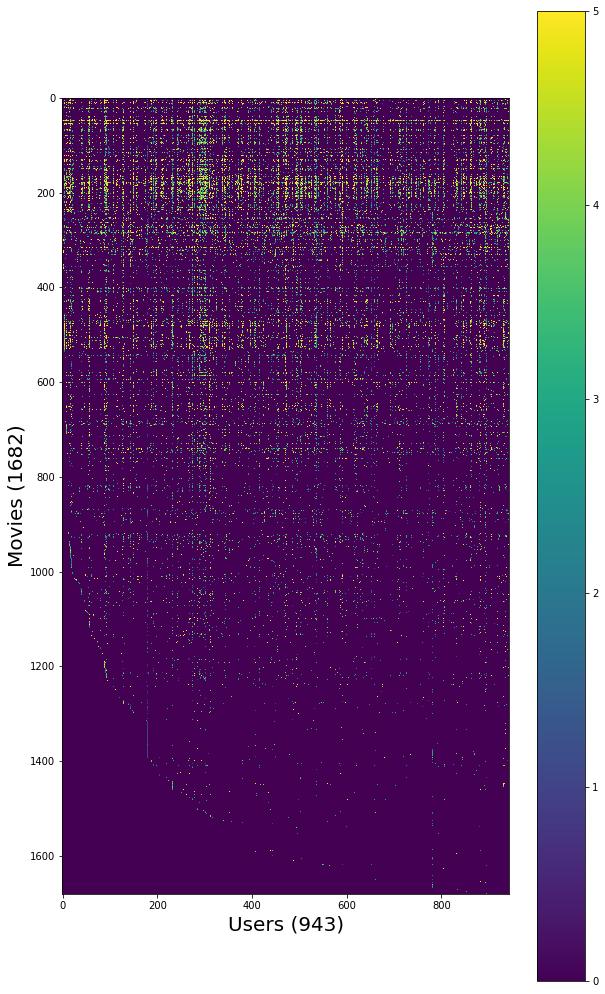

In [0]:
fig = plt.figure(figsize=(10,10*(1682./943.)))
plt.imshow(Y)
plt.colorbar()
plt.ylabel('Movies (%d)'%num_movies,fontsize=20)
plt.xlabel('Users (%d)'%num_users,fontsize=20)
plt.show()

## 2. Find related movies based on the features

### 2.1 How to find "Similar" movies

For each product $i$, we have or learn a feature vector $x^{(i)} \in \mathbb{R}^{n}$

e.g. $x_1$ = romance, $x_2$ = action, $x_3$ = comedy, ..., $x_n$ =...

Small Norm of $||x^{(i)} - x^{(j)}||$ means $j$ and $i$ are ***SIMILAR***

5 most similar movies to movie $i:$

Find the 5 movies $j$ with the smallest Norm $||x^{(i)} - x^{(j)}||$

### 2.2 What is the Norm of a Vector

The Norm is the "size" or "length" of the vector, it is defined as:

$L_1 Norm:  \qquad \displaystyle  ||x||_1 = |x_1| + |x_2| + \dots + |x_n| = \sum_i^n |x_i| $

$L_2 Norm:  \qquad \displaystyle  ||x||_2 = (|x_1|^2 + |x_2|^2+\dots+ |x_n|^2)^{\frac{1}{2}} =\sqrt{ \sum_i^n x_i^2}$

$L_p Norm:  \qquad \displaystyle  ||x||_p = (|x_1|^p + |x_2|^p+\dots+ |x_n|^p)^{\frac{1}{p}} =\sqrt[p]{ \sum_i^n x_i^p}$

We are using numpy.linalg.norm to calculate the Norm of vector.

### 2.3 Pick a movie, we are going to find its similar movies based on the feature X

In [0]:
theMovie = 'Toy Story (1995)'

print("The GOAL is to find movies that similar to: ", theMovie)
#items.loc[items['movie_title'] == theMovie]


The GOAL is to find movies that similar to:  Toy Story (1995)


In [0]:
item_idx = items.loc[items['movie_title'] == theMovie]['movie_id'].values[0]
v = X[item_idx]

n = la.norm((X-v), axis=1)
items['norm'] = n

### 2.4 The top 10 similar movies

In [0]:
print("THE TOP TEN MOVIES SIMILAR TO: ", theMovie)
items.sort_values(by=['norm']).head(10)[['norm', 'movie_title', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Musical', 'Mystery','Romance','Sci-Fi']]


THE TOP TEN MOVIES SIMILAR TO:  Toy Story (1995)


,norm,movie_title,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Musical,Mystery,Romance,Sci-Fi
0,0.0,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0
421,0.0,Aladdin and the King of Thieves (1996),0,0,1,1,1,0,0,0,0,0,0,0,0
239,1.0,Beavis and Butt-head Do America (1996),0,0,1,0,1,0,0,0,0,0,0,0,0
62,1.0,"Santa Clause, The (1994)",0,0,0,1,1,0,0,0,0,0,0,0,0
1065,1.0,Balto (1995),0,0,1,1,0,0,0,0,0,0,0,0,0
1077,1.0,Oliver & Company (1988),0,0,1,1,0,0,0,0,0,0,0,0,0
624,1.0,"Sword in the Stone, The (1963)",0,0,1,1,0,0,0,0,0,0,0,0,0
622,1.0,Angels in the Outfield (1994),0,0,0,1,1,0,0,0,0,0,0,0,0
93,1.0,Home Alone (1990),0,0,0,1,1,0,0,0,0,0,0,0,0
94,1.0,Aladdin (1992),0,0,1,1,1,0,0,0,0,1,0,0,0


## 3. Content Based Recommender System Model

We already have the feature matrix $X$ which is read from the dataset, now we are going to build a content based model to calculate $\theta$ which is to predict user ratings.

### 3.1 Build and train the model

**Given features $x^{(1)},...,x^{(n_m)}, \textrm{ to calculate  }\theta^{(1)},...,\theta^{(n_u)} \textrm{:}$**

**Cost Function:**

$\qquad \displaystyle\min_{\theta^{(1)},...,\theta^{(n_u)} } J = \frac{1}{2}\sum_{j=1}^{n_u}\sum_{i:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2 + \frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^n(\theta_k^{(j)})^2$


**Gradient Decent:**

$\qquad \displaystyle\frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{j:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})x_k^{(i)}+\lambda \theta_k^{(j)}$

In [0]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row)
    This is important because without this, a user who hasn't rated any movies
    will have a predicted score of 0 for every movie, when in reality
    they should have a predicted score of [average score of that movie].
    """

    # The mean is only counting movies that were rated
    Ymean = np.sum(Y,axis=1)/np.sum(R,axis=1)
    Ymean = Ymean.reshape((Ymean.shape[0],1))
    
    return Y-Ymean, Ymean
  
  
def flattenParams(Theta):
    """
    Hand this function an X matrix and a Theta matrix and it will flatten
    it into into one long (nm*nf + nu*nf,1) shaped numpy array
    """
    return Theta.flatten()

# A utility function to re-shape the X and Theta will probably come in handy
def reshapeParams(flattened_Theta, num_users, num_features):
    assert flattened_Theta.shape[0] == int(num_users*num_features)
    
    reTheta = flattened_Theta[:int(num_users*num_features)].reshape((num_users,num_features))
    
    return reTheta  

In [0]:
def cofiCostFunc(params, X, Y, R, num_users, num_movies, num_features, lambda_=0):
    #COFICOSTFUNC Collaborative filtering cost function
    #   [J, grad] = COFICOSTFUNC(params, Y, R, num_users, num_movies, ...
    #   num_features, lambda) returns the cost and gradient for the
    #   collaborative filtering problem.
    #
    
    Theta = reshapeParams(params, num_users, num_features)

    # These are the return values
    J = 0
    Theta_grad = np.zeros(Theta.shape)
    
    
    ### COST FUNCTION
    # X * Theta performed according to low rank matrix vectorization
    squared_error = np.power(np.dot(X,Theta.T) - Y,2)

    # for cost function, sum only i,j for which R(i,j)=1
    J = (1/2.) * np.sum(squared_error * R)
    J = J + (lambda_/2.)*( np.sum( np.power(Theta, 2) ) + np.sum( np.power(X, 2) ) )

    ### GRADIENTS

    Theta_grad = np.dot((( np.dot(X, Theta.T) - Y ) * R).T, X)
    Theta_grad = Theta_grad + lambda_*Theta
    
    grad = flattenParams(Theta_grad)
    
    return J, grad

In [0]:
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = X.shape[1]

Ynorm, Ymean = normalizeRatings(Y,R)

In [0]:
# Set Initial Parameters (Theta)
Theta = np.random.randn(num_users, num_features)

initial_parameters  = flattenParams(Theta)

# Set options
maxiter = 100
options = {'disp': True, 'maxiter':maxiter}
lambda_=10

In [0]:
from scipy.optimize import minimize

# Create "short hand" for the cost function to be minimized
def costFunc(initial_parameters):
    return cofiCostFunc(initial_parameters, X, Y, R, num_users, num_movies, num_features, lambda_)


results = minimize(costFunc, x0=initial_parameters, options=options, method="L-BFGS-B", jac=True)


### 3.2 Visualize the predicted ratings

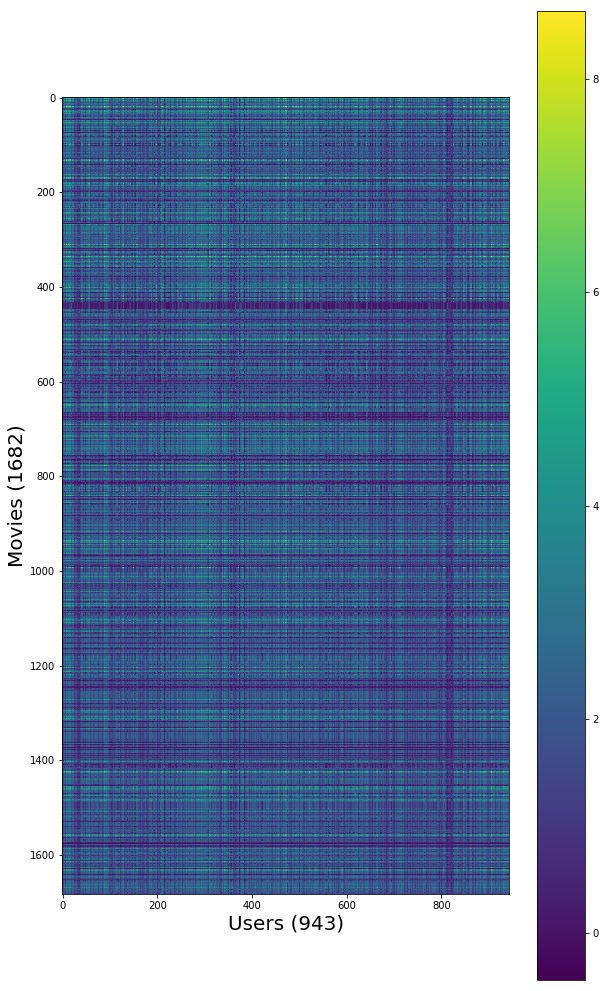

In [0]:
Theta = reshapeParams(results['x'], num_users, num_features)
prediction_matrix = X.dot(Theta.T)

fig = plt.figure(figsize=(10,10*(1682./943.)))
plt.imshow(prediction_matrix)
plt.colorbar()
plt.ylabel('Movies (%d)'%num_movies,fontsize=20)
plt.xlabel('Users (%d)'%num_users,fontsize=20)
plt.show()

### 3.3 Predict rating for a new user

In [0]:
new_ratings = np.zeros((Y.shape[0],1))
new_ratings[0]   = 4
new_ratings[97]  = 2
new_ratings[6]   = 3
new_ratings[11]  = 5
new_ratings[53]  = 4
new_ratings[63]  = 5
new_ratings[65]  = 3
new_ratings[68]  = 5
new_ratings[182] = 4
new_ratings[225] = 5
new_ratings[354] = 5

In [0]:
# Add new ratings to the Y matrix, and the relevant row to the R matrix
new_R = new_ratings > 0
Y = np.hstack((Y,new_ratings))
R = np.hstack((R,new_R))

num_movies, num_users = Y.shape
num_features = X.shape[1]

Ynorm, Ymean = normalizeRatings(Y,R)

In [0]:
# Set Initial Parameters (Theta)
Theta = np.random.randn(num_users, num_features)

initial_parameters  = flattenParams(Theta)

# Set options
maxiter = 100
options = {'disp': True, 'maxiter':maxiter}
lambda_=10

results = minimize(costFunc, x0=initial_parameters, options=options, method="L-BFGS-B", jac=True)

Theta = reshapeParams(results['x'], num_users, num_features)
prediction_matrix = X.dot(Theta.T)

In [0]:
# After training the model, now make recommendations by computing
# the predictions matrix
prediction_matrix = X.dot(Theta.T)

# Grab the last user's predictions (since I put my predictions at the
# end of the Y matrix, not the front)
# Add back in the mean movie ratings
new_predictions = prediction_matrix[:,-1] + Ymean.flatten()

# Sort new predictions from highest to lowest
pred_idxs_sorted = np.argsort(new_predictions)
pred_idxs_sorted[:] = pred_idxs_sorted[::-1]

In [0]:
print( "Top recommendations for new user:" )
for i in range(10):
    print( 'Predicting rating %0.1f for movie #%d: %s.' % \
    (new_predictions[pred_idxs_sorted[i]], pred_idxs_sorted[i],items.loc[pred_idxs_sorted[i]].movie_title)  )
    
print( "\nThe ratings provided:" )
for i in range(len(new_ratings)):
    if new_ratings[i] > 0:
        print( 'Rated %d for movie #%d: %s.' % (new_ratings[i], i, items.loc[i].movie_title)  )

Top recommendations for new user:
Predicting rating 7.3 for movie #171: Empire Strikes Back, The (1980).
Predicting rating 6.8 for movie #854: Diva (1981).
Predicting rating 6.8 for movie #407: Close Shave, A (1995).
Predicting rating 6.7 for movie #175: Aliens (1986).
Predicting rating 6.7 for movie #49: Star Wars (1977).
Predicting rating 6.6 for movie #128: Bound (1996).
Predicting rating 6.6 for movie #182: Alien (1979).
Predicting rating 6.5 for movie #489: To Catch a Thief (1955).
Predicting rating 6.5 for movie #134: 2001: A Space Odyssey (1968).
Predicting rating 6.5 for movie #54: Professional, The (1994).

The ratings provided:
Rated 4 for movie #0: Toy Story (1995).
Rated 3 for movie #6: Twelve Monkeys (1995).
Rated 5 for movie #11: Usual Suspects, The (1995).
Rated 4 for movie #53: Outbreak (1995).
Rated 5 for movie #63: Shawshank Redemption, The (1994).
Rated 3 for movie #65: While You Were Sleeping (1995).
Rated 5 for movie #68: Forrest Gump (1994).
Rated 2 for movie #97: